In [74]:
import numpy as np
import scipy as sp
import pandas as pd
 
import matplotlib.pyplot as plt
import matplotlib as mpl
 
import math
 
from scipy import stats
from scipy.stats import norm
 
#from scipy.optimize import curve_fit
#from lmfit import Model

In [75]:
def DetermineBursts(group, ignore_dark): #Identifies the bright segments, ignoring dark times below the specified threshold
    bursts = []
    ignore_dark = ignore_dark+1
    burst = []
    previous_frame = -10000
    for index, row in group.iterrows():
        frame = row["frame"]
        if frame - previous_frame <= ignore_dark:
            burst.append(frame)
        else:
            bursts.append(burst)
            burst = []
            burst.append(frame)
        previous_frame = frame
    bursts.append(burst)
    return(bursts[1:]) #The first entry of bursts is always [], so it can be discarded
 
def CalculateBright_halfapprox(bursts): #Calculates the lengths of the bright times
    brights = []
    for entry in bursts:
        brights.append(entry[-1]-entry[0]+0.5)
    return(brights)
 
def CalculateDark_halfapprox(bursts): #Calculates the lengths of the dark times
    darks = []
    last = 0
    for entry in bursts:
        first = entry[0]
        difference = first-last
        last = entry[-1]
        darks.append(difference-0.5)
    return(darks[1:]) #The first entry is discarded, as it is just the time from the start of the measurement until the first bright segment
 
def CalculateDark(bursts): #Calculates the lengths of the dark times
    darks = []
    previous_first = 0
    for entry in bursts:
        first = entry[0]
        difference = first-previous_first
        previous_first = first
        darks.append(difference-1)
    return(darks[1:])
    
def LinkLocalizations(group, ignore_dark):
    bursts = DetermineBursts(group, ignore_dark)
    dark = CalculateDark(bursts)
    bright_halfapprox = CalculateBright_halfapprox(bursts)
    return(bright_halfapprox, dark, bursts)

def LinkLocalizationsOld(group, ignore_dark):
    bursts = DetermineBursts(group, ignore_dark)
    dark_halfapprox = CalculateDark_halfapprox(bursts)
    bright_halfapprox = CalculateBright_halfapprox(bursts)
    return(bright_halfapprox, dark_halfapprox, bursts)

def Import(input_path):
    fulltable = pd.read_hdf(input_path, key = 'locs')
    betterfulltable = fulltable.sort_values(by=['group', 'frame'])
    return(betterfulltable)

In [182]:
def DoStuff(fulltable, ignore_dark):
    bright_time_table = []
    dark_time_table = []
    bursts_table = []
    index_table = []
    number_of_binding_events_per_site = []

    for i in range(max(fulltable["group"])+1): 
        bright_time, dark_time, bursts = LinkLocalizations((fulltable[fulltable["group"] == (i) ]), ignore_dark)
        if bursts != []:
            bright_time_table.append(bright_time)
            dark_time_table.append(dark_time)
            bursts_table.append(bursts)
            number_of_binding_events_per_site.append(len(bursts))
    
    number_of_binding_events_per_site = np.asarray(number_of_binding_events_per_site)
    return(number_of_binding_events_per_site)

def PlotStuff(number_of_binding_events_per_site, title):
    mpl.style.use('seaborn-poster')
    bins=range(int(number_of_binding_events_per_site.min()), int(number_of_binding_events_per_site.max()) + 2, 2)
    fig = plt.figure(figsize=(8, 8))
    fig.tight_layout()
    entries, bins, patches = plt.hist(number_of_binding_events_per_site, bins=bins, density=True, label='', color = "skyblue", alpha = 0.6)
    bin_middles = 0.5 * (bins[1:] + bins[:-1])
    (mu1, sigma1) = norm.fit(number_of_binding_events_per_site)
    xax = np.linspace(0, max(number_of_binding_events_per_site)+1, 10000)
    best_fit_line1 = sp.stats.norm.pdf(xax, mu1, sigma1)
    plt.plot(xax, best_fit_line1, color = "darkorange", label = "Max (center) = "+str(int(np.round(mu1))))
    plt.legend()
    plt.title(title)
    plt.show()
    
def _1gaussian(x_array, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2)))
    
def _2gaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2)))
    
def PlotStuffBetter(number_of_binding_events_per_site, title):
    mpl.style.use('seaborn-poster')
    bins=range(int(number_of_binding_events_per_site.min()), int(number_of_binding_events_per_site.max()) + 2, 2)
    fig = plt.figure(figsize=(8, 8))
    fig.tight_layout()
    entries, bins, patches = plt.hist(number_of_binding_events_per_site, bins=bins, density=True, label='', color = "pink", alpha = 0.6)
    bin_middles = 0.5 * (bins[1:] + bins[:-1])
    (mu1, sigma1) = norm.fit(number_of_binding_events_per_site)
    
    x_array = bin_middles
    y_array_2gauss = entries
    
    [amp1, cen1, sigma1, amp2, cen2, sigma2] = [0.1,mu1-sigma1,sigma1/2,0.1,mu1+sigma1,sigma1/2]
    
    popt_2gauss, pcov_2gauss = sp.optimize.curve_fit(_2gaussian, x_array, y_array_2gauss, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
    perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
    
    pars_1 = popt_2gauss[0:3]
    pars_2 = popt_2gauss[3:6]
    
    xax = np.linspace(0, max(number_of_binding_events_per_site)+1, 10000)
    
    gauss_peak_1 = _1gaussian(xax, *pars_1)
    gauss_peak_2 = _1gaussian(xax, *pars_2)
    
    double_gauss = _2gaussian(xax, *popt_2gauss)
    
    plt.plot(xax, gauss_peak_2, "y", label = "Left peak = "+str(np.round(pars_2[1],1)))
    plt.plot(xax, gauss_peak_1, "g", label = "Right peak = "+str(np.round(pars_1[1],1)))
    
    plt.plot(xax, double_gauss, "black", linestyle='dashed', linewidth = 0.7, label = "Two-Gaussian fit line")
    
    plt.xlim(0, 2.5*pars_1[1])
    
    #(mu1, sigma1) = norm.fit(number_of_binding_events_per_site)
    #xax = np.linspace(0, max(number_of_binding_events_per_site)+1, 10000)
    #best_fit_line1 = sp.stats.norm.pdf(xax, mu1, sigma1)
    #plt.plot(xax, best_fit_line1, color = "darkorange", label = "Max (center) = "+str(int(np.round(mu1))))
    plt.legend()
    plt.title(title)
    plt.show()

In [181]:
pathR1 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R1_7nt_150pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"
pathR2 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R2_7nt_100pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"
pathR3 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R3_7nt_100pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"
pathR4 = "/Volumes/pool-miblab4/users/reinhardt/z_raw/Resi/220125_Nup96-GFP_4c/aligned/R4_7nt_100pM_18mW_150ms_561_1_MMStack_Pos0.ome_locs_render_render_filter_aligned_apicked_ClusterD11_10_22.0.hdf5"

fulltable1 = Import(pathR1)
fulltable2 = Import(pathR2)
fulltable3 = Import(pathR3)
fulltable4 = Import(pathR4)

ignore_dark = 0

In [210]:
print(fulltable1)
R1 = DoStuff(fulltable1, ignore_dark)
R2 = DoStuff(fulltable2, ignore_dark)
R3 = DoStuff(fulltable3, ignore_dark)
R4 = DoStuff(fulltable4, ignore_dark)

       frame           x           y           z      photons        sx  \
0       1328  279.390442  228.027054  118.173836   920.784607  1.583958   
9       3426  279.429596  227.988220  121.026833  2912.892334  1.618554   
10      3427  279.439301  228.021729   98.397095  2671.662109  1.474893   
24      5811  279.463287  228.022675  110.896126  2893.474854  1.554853   
41      6974  279.489777  227.992706  102.569832  2814.249756  1.522682   
...      ...         ...         ...         ...          ...       ...   
47613  10100  255.395447  196.137665   29.858704  3677.558105  1.279210   
47614  10102  255.414185  196.139145   30.658085  3745.803223  1.217594   
47615  10103  255.401154  196.119064   39.184605  3956.820557  1.277455   
47616  10104  255.322098  196.210327   49.593266  2206.652832  1.333863   
47617  10628  255.368317  196.229736   51.861904  1580.970947  1.317160   

             sy         bg       lpx       lpy  ellipticity  net_gradient  \
0      0.927779  44.37

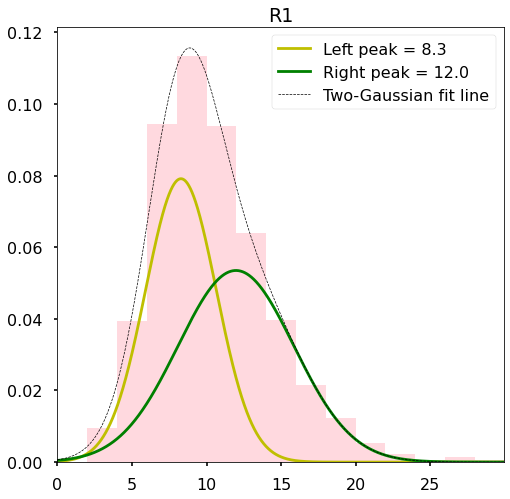

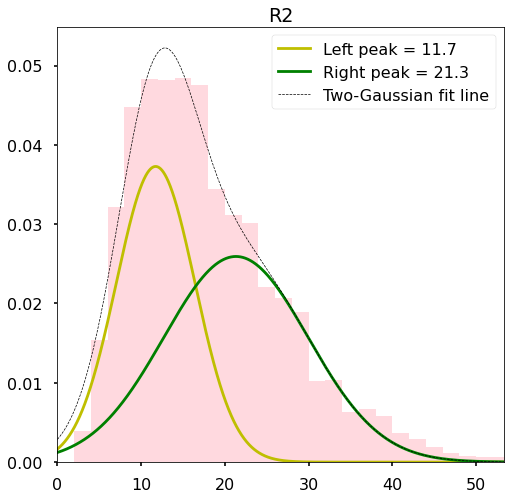

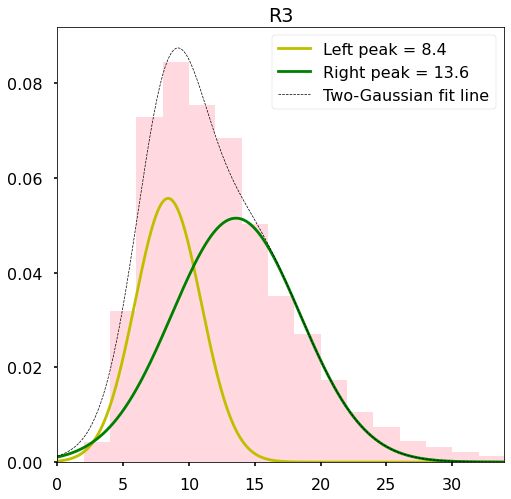

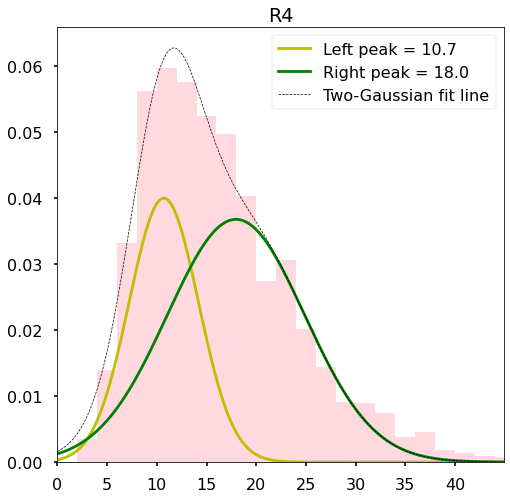

In [184]:
#PlotStuff(R1, "R1")
PlotStuffBetter(R1, "R1")
#PlotStuff(R2, "R2")
PlotStuffBetter(R2, "R2")
#PlotStuff(R3, "R3")
PlotStuffBetter(R3, "R3")
#PlotStuff(R4, "R4")
PlotStuffBetter(R4, "R4")

In [209]:
cmap = plt.get_cmap("hot")
print(cmap(0))

(0.0416, 0.0, 0.0, 1.0)
